# What does this project do?

- point cloud of object generated using depth and segmentation model
- applications in robotics
- better than alternatives, as runtime is significantly decreased


- Maybe view consistent editable nerfs?
- Split into parts and then use diffusion models to edit it

 - Remove points that are far away from other points
 - Fill in areas with high concentration of points

- put the point cloud in nerf
- train the nerf
- use the point cloud and a diffusion model to supervise on new poses

- text supervised nerf
- use the text to make the nerf better

- add depth estimation model

# Prereqs

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Optional

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

# CLIP Setup

In [50]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
classes = cifar100.classes

ModuleNotFoundError: No module named 'clip'

In [ ]:
preprocess
from torchvision import transforms
resize = transforms.Resize(size=224, interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=None)
crop = transforms.CenterCrop(size=(224, 224))
normalize = transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))

# Data Setup

## Load LLFF

In [4]:
from nerf import load_llff_data
images, poses, bds, render_poses, i_test = load_llff_data("C:\\Users\\victo\\Desktop\\Files\\Tech\\Data\\horns\\", factor=8)
hwf = poses[0, :3, -1]
poses = poses[:, :3, :4]
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]
images = torch.from_numpy(images)
poses = torch.from_numpy(poses)
tform_cam2world = poses
focal_length = focal
height,width = H,W

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\victo\\Desktop\\Files\\Tech\\Data\\horns\\poses_bounds.npy'

In [ ]:
# poses_arr = np.load(os.path.join(base_dir,"poses_bounds.npy"))
# poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1, 2, 0])
# sh = images[0].shape
# poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1])
# poses[2, 4, :] = poses[2, 4, :] * 1.0 / 8
# poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
# poses = np.moveaxis(poses, -1, 0).astype(np.float32)

tform_cam2world = []
for i in range(len(poses)):
    empty = np.array([[0,0,0,1]])
    new_pose = np.concatenate((poses[i][:,:4],empty),0)
    
    tform_cam2world.append(torch.Tensor(new_pose))
tform_cam2world = torch.stack(tform_cam2world)

## Load Blender

In [4]:
from nerf.load_blender import load_blender_data
base_dir = r"C:\Users\victo\Desktop\Files\Tech\Data\nerf_synthetic\nerf_synthetic\chair"
images, poses, render_poses, hwf, i_split = load_blender_data(
                base_dir,
                half_res=True,
                testskip=0
            )
images = images[:,:,:,:3][:100]
H, W, focal = hwf
height,width,focal_length = H,W,focal
len(images)

100

In [5]:
testimg = images[10]
testpose = poses[10]
near_thresh = 2
far_thresh = 6
tform_cam2world = poses

## Load Lego Bulldozer

In [ ]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

In [ ]:
tform_cam2world.shape

# Helper Functions

In [6]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.
  
  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.
  
  return cumprod

In [7]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.
  
  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

In [8]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".
  
  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

In [9]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  
  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

In [10]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).
  
  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

In [11]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

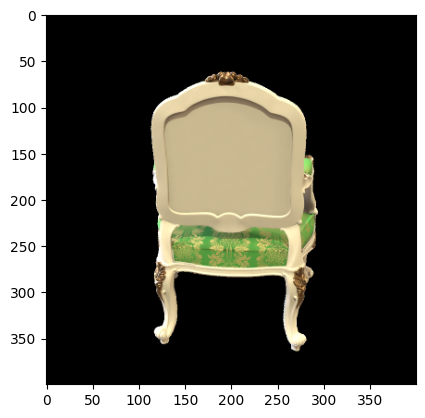

In [12]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

# CLIP Functions

In [ ]:
import torchvision.transforms as transforms
    
perspective = transforms.RandomPerspective()
flip = transforms.RandomHorizontalFlip()
affine = transforms.RandomAffine(10)
jitter = transforms.ColorJitter()
def augment_img(img):
    augmented_img = img
    augmented_img = perspective.forward(augmented_img)
    augmented_img = flip.forward(augmented_img)
    augmented_img = affine.forward(augmented_img)
    augmented_img = jitter.forward(augmented_img)
    return augmented_img

In [ ]:
suitable_class = "lawn_mower"
target_logits = torch.zeros(len(classes)).to(device)
target_logits[classes.index(suitable_class)] = 1
class_target_logits = torch.reshape(target_logits,(1,100)).to(device)

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Complex text input
descriptive_text = clip.tokenize("a lego excavator").to(device)

def class_clip(rgb_predicted,target_img,rgb_weightage = 1, clip_weightage = 0.5):
    image = torch.Tensor(rgb_predicted)
    rgb = torch.dsplit(image,3)
    transformed = torch.stack(rgb).reshape(3,100,100)
    resized = resize(transformed)
    normalized = normalize(resized.unsqueeze(0).to(device))
    cosine_similarities = clip_model(normalized,text_inputs)[0]
    softmax = torch.nn.Softmax(dim=1)
    logits  = softmax(cosine_similarities)
    crossentropy = torch.nn.CrossEntropyLoss()
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)*rgb_weightage + crossentropy(target_logits,logits)*clip_weightage
    return loss

def descriptive_clip(rgb_predicted,target_img,rgb_weightage = 1, clip_weightage = 0):
    image = torch.Tensor(rgb_predicted)
    rgb = torch.dsplit(image,3)
    transformed = torch.stack(rgb).reshape(3,100,100)
    resized = resize(transformed)
    normalized = normalize(resized).unsqueeze(0).to(device)
    cosine_similarity = clip_model(normalized,descriptive_text)[0].to(device)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)*rgb_weightage + -torch.log(cosine_similarity)*clip_weightage
    return loss

In [ ]:
plt.imshow(testimg.cpu())

In [ ]:
import torch
from PIL import Image
def truncate(val):
    if val > 0:
        return 1
    else:
        return 0
# descriptive_text = clip.tokenize("yellow excavator").to(device)
sigmoid = torch.nn.Sigmoid()
relu = torch.nn.ReLU()
# image = torch.clone(testimg)

def split_img(im,M,N):
    return [[im[x:x+M,y:y+N],(x,M),(y,N)] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

def similarity(img,text_input):
    descriptive_text = clip.tokenize(text_input).to(device)
    shape = img.shape
    rgb = torch.dsplit(img,3)
    transformed = torch.stack(rgb).reshape(shape[-1],shape[0],shape[1])
    resized = resize(transformed)
    normalized = normalize(resized).unsqueeze(0).to(device)
    cosine_similarity = clip_model(normalized,descriptive_text)[0].to(device)
    return cosine_similarity

def clear_tile(img,x_vals,y_vals,size = 5):
    x,M = x_vals
    y,N = y_vals
    #print(img.shape)
    #print(x,y+20)
    for a in range(x,x+size):
        for b in range(y,y+size):
            img[a][b] = torch.Tensor([0,0,0])
            
    return img

def find_grads(text_input,image,augments = 0):
    shape = image.shape
    descriptive_text = clip.tokenize(text_input).to(device)
    image = torch.clone(image)
    image.requires_grad = True

    loss = 0
    if augments:
        for i in range(augments):
            augmented = augment_img(image)
            rgb = torch.dsplit(augmented,3)
            transformed = torch.stack(rgb).reshape(shape[-1],shape[0],shape[1])
            resized = resize(transformed)
            normalized = normalize(resized).unsqueeze(0).to(device)
            cosine_similarity = clip_model(normalized,descriptive_text)[0].to(device)
            loss += -cosine_similarity
    else:
        image.requires_grad = True
        rgb = torch.dsplit(image,3)
        transformed = torch.stack(rgb).reshape(shape[-1],shape[0],shape[1])
        resized = resize(transformed)
        normalized = normalize(resized).unsqueeze(0).to(device)
        cosine_similarity = clip_model(normalized,descriptive_text)[0].to(device)
        loss = -cosine_similarity
    loss.backward()
    grads = relu(image.grad.cpu())
    return grads

def generate_mask(img,size = 5,scale = 1.1):
    tiles = split_img(img,size,size)
    min_score = similarity(torch.zeros(tiles[0][0].shape),"yellow lego bulldozer")
    mask = torch.ones(img.shape)
    for i in range(len(tiles)):
        score = similarity(tiles[i][0],"yellow lego bulldozer")
        #print(tiles[i][1:])
        #print(score)
        if score < min_score*scale:
            mask = clear_tile(mask,tiles[i][1],tiles[i][2],size=size)
    return mask

#monkey = Image.open("monkey.jpg")
#monkey = monkey.resize((100,100))
#monkey_ = torch.Tensor(np.array(monkey)/255)

#monkey = torch.clone(monkey_)


empty = find_grads("",testimg,augments = 0)
extra = find_grads("yellow lego bulldozer",testimg,augments = 0)
mask = generate_mask(testimg,size = 10)
plt.imshow((extra-empty)*mask)

# Model Initialisation

In [ ]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu
  
  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

In [ ]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):
  
  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)
  
  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

In [ ]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 4
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 1000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Training

In [ ]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 1000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)
    
    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

In [ ]:
print(tform_cam2world.shape)

# Discern "True" Points

- Find points that are important to CLIP
- Real point must exist along intersection between two important points
- Record all rays that pass through "important points"
- real points exist on the intersection of these rays

Revised:
- As the creation is not perfect, create heatmap of points that exists close to the vectors as important
- Precondition points close to it to be higher density
- Set certainties by proximity to line intersections

Todo:
- Write function to find points and weightages that are close to the intersection of lines
- Write function to condition network to the high density values (rgb of point), assign uncertanity of points to average importance of two rays
- When rendering, can only render those with higher certainties
- visualise with importance as density, and save radiance

Prototype 1:
- strange points are found, try simplifying and observing what happens
- maybe assign close points to the same.

In [14]:
depth_samples_per_ray = 32
target_img_idx = np.random.randint(images.shape[0])
target_img = images[target_img_idx].to(device)
target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               target_tform_cam2world)
  
query_points, depth_values = compute_query_points_from_rays(
    ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
)

# query points are width, height by samples for each pixel
# depth values are the depth of the point from the source
query_points

c:\ProgramData\Miniconda3\envs\nerfresearch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[[ 1.4318e+00,  6.4625e-01,  1.6008e+00],
          [ 1.3767e+00,  4.8500e-01,  1.5754e+00],
          [ 1.3399e+00,  3.7716e-01,  1.5585e+00],
          ...,
          [ 6.2727e-02, -3.3660e+00,  9.6924e-01],
          [ 2.1079e-02, -3.4881e+00,  9.5002e-01],
          [ 1.6465e-03, -3.5450e+00,  9.4106e-01]],

         [[ 1.4191e+00,  6.2014e-01,  1.5963e+00],
          [ 1.3553e+00,  4.3397e-01,  1.5670e+00],
          [ 1.3365e+00,  3.7911e-01,  1.5584e+00],
          ...,
          [ 6.5512e-02, -3.3271e+00,  9.7435e-01],
          [ 4.1736e-02, -3.3964e+00,  9.6343e-01],
          [-2.8656e-02, -3.6017e+00,  9.3108e-01]],

         [[ 1.4410e+00,  6.9444e-01,  1.6077e+00],
          [ 1.3595e+00,  4.5797e-01,  1.5704e+00],
          [ 1.3362e+00,  3.9046e-01,  1.5597e+00],
          ...,
          [ 5.2442e-02, -3.3345e+00,  9.7217e-01],
          [ 1.4696e-02, -3.4440e+00,  9.5489e-01],
          [-3.3206e-02, -3.5830e+00,  9.3297e-01]],

         ...,

         [[ 2.63

# Ray Intersection Point (redundant)

In [ ]:
# ! a ray can be expressed as the ray direction and ray origin
from IPython.display import clear_output
grads = []
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
threshold = 0.4

# ray origin, ray  direction, importance
important_rays = []
point_colors = []

dec = 3
for i in range(len(images)):
    image = images[i].to(device)
    transform = tform_cam2world[i].to(device)
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               transform)
    query_points, depth_values = compute_query_points_from_rays(
    ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray)
    empty = find_grads("",image,augments = 0)
    extra = find_grads("yellow lego bulldozer",image,augments = 0)
    mask = generate_mask(image,size = 10)
    
    cleaned_grads = (extra-empty)*mask
    
    mask_overlay = np.zeros((100,100,1))
    img_rays = []
    img_clrs = []
    for x in range(cleaned_grads.shape[0]):
        for y in range(cleaned_grads.shape[1]):
            if sum(cleaned_grads[x][y]) > threshold:
                # pixel x,y is semantically important
                ray_origin = ray_origins[x][y]
                ray_direction = ray_directions[x][y]
                importance = cleaned_grads[x][y]
                
                record = [list(np.round(ray_origin.cpu().numpy(),decimals = dec)),
                          list(np.round(ray_direction.cpu().numpy(),decimals = dec)),
                          sum(importance)]
                if not(record in important_rays):
                    img_rays.append(record)
                    img_clrs.append(image[x][y])
                    #print(record[-1])
                    mask_overlay[x][y] = torch.sigmoid(record[-1])
                    #print(torch.sigmoid(record[-1]))
    important_rays.append(img_rays)
    point_colors.append(img_clrs)
    plt.imshow(image.cpu().numpy())
    plt.imshow(mask_overlay, alpha = 0.6, cmap = "magma")
    plt.show()
    print(i,len(img_rays))
    
    if i % 10 == 0:
        clear_output()
    grads.append(cleaned_grads)

In [ ]:
# find closest point for two given rays.
# most likely to be the point of intersection (i.e point of reality)
# increase density of that point and points around it,
from numpy import array, cross
from numpy.linalg import solve, norm

def closest_point(ray_1,ray_2,clampAll=False,clampA0=False,clampA1=False,clampB0=False,clampB1=False):

    ''' Given two lines defined by numpy.array pairs (a0,a1,b0,b1)
        Return the closest points on each segment and their distance
    '''

    o_1,d_1,i_1 = ray_1
    o_2,d_2,i_2 = ray_2
    
    o_1,d_1 = np.array(o_1),np.array(d_1)
    o_2,d_2 = np.array(o_2),np.array(d_2)
    
    a0 = o_1
    a1 = o_1+d_1
    
    b0 = o_2
    b1 = o_2+d_2
    # If clampAll=True, set all clamps to True
    if clampAll:
        clampA0=True
        clampA1=True
        clampB0=True
        clampB1=True


    # Calculate denomitator
    A = a1 - a0
    B = b1 - b0
    magA = np.linalg.norm(A)
    magB = np.linalg.norm(B)
    
    _A = A / magA
    _B = B / magB
    
    cross = np.cross(_A, _B);
    denom = np.linalg.norm(cross)**2
    
    
    # If lines are parallel (denom=0) test if lines overlap.
    # If they don't overlap then there is a closest point solution.
    # If they do overlap, there are infinite closest positions, but there is a closest distance
    if not denom:
        d0 = np.dot(_A,(b0-a0))
        
        # Overlap only possible with clamping
        if clampA0 or clampA1 or clampB0 or clampB1:
            d1 = np.dot(_A,(b1-a0))
            
            # Is segment B before A?
            if d0 <= 0 >= d1:
                if clampA0 and clampB1:
                    if np.absolute(d0) < np.absolute(d1):
                        return (a0+b0)/2,((i_1+i_2)/2)/np.linalg.norm(a0-b0)
                    return (a0+b1)/2,((i_1+i_2)/2)/np.linalg.norm(a0-b1)
                
                
            # Is segment B after A?
            elif d0 >= magA <= d1:
                if clampA1 and clampB0:
                    if np.absolute(d0) < np.absolute(d1):
                        return (a1+b0)/2,((i_1+i_2)/2)/np.linalg.norm(a1-b0)
                    return (a1+b1)/2,((i_1+i_2)/2)/np.linalg.norm(a1-b1)
                
                
        # Segments overlap, return distance between parallel segments
        return None,((i_1+i_2)/2)/np.linalg.norm(((d0*_A)+a0)-b0)
        
    
    
    # Lines criss-cross: Calculate the projected closest points
    t = (b0 - a0);
    detA = np.linalg.det([t, _B, cross])
    detB = np.linalg.det([t, _A, cross])

    t0 = detA/denom;
    t1 = detB/denom;

    pA = a0 + (_A * t0) # Projected closest point on segment A
    pB = b0 + (_B * t1) # Projected closest point on segment B


    # Clamp projections
    if clampA0 or clampA1 or clampB0 or clampB1:
        if clampA0 and t0 < 0:
            pA = a0
        elif clampA1 and t0 > magA:
            pA = a1
        
        if clampB0 and t1 < 0:
            pB = b0
        elif clampB1 and t1 > magB:
            pB = b1
            
        # Clamp projection A
        if (clampA0 and t0 < 0) or (clampA1 and t0 > magA):
            dot = np.dot(_B,(pA-b0))
            if clampB0 and dot < 0:
                dot = 0
            elif clampB1 and dot > magB:
                dot = magB
            pB = b0 + (_B * dot)
    
        # Clamp projection B
        if (clampB0 and t1 < 0) or (clampB1 and t1 > magB):
            dot = np.dot(_A,(pB-a0))
            if clampA0 and dot < 0:
                dot = 0
            elif clampA1 and dot > magA:
                dot = magA
            pA = a0 + (_A * dot)

    midpoint = (pA+pB)/2
    return midpoint,((i_1+i_2)/2)/(np.linalg.norm(pA-pB)+1)

def get_ray(origin,direction,num_pts=10):
    origin = np.array(origin)
    direction = np.array(direction)
    pts = ray_origins[x]
    # Data for a three-dimensional line
    pts = [origin+direction*i for i in range(num_pts)]
    xdata = [pt[0] for pt in pts]
    ydata =  [pt[1] for pt in pts]
    zdata = [pt[2] for pt in pts]
    return xdata,ydata,zdata

In [ ]:
import plotly.graph_objects as go
import random

idx_1 = random.randint(1,len(important_rays))
idx_2 = random.randint(1,len(important_rays))

ray_1 = important_rays[idx_1][idx_2]
ray_2 = important_rays[idx_2][idx_1]

#ray_1 = [torch.Tensor([1,0,0]),torch.Tensor([0,1,1]),1]
#ray_2 = [torch.Tensor([0,0,0]),torch.Tensor([0,0,1]),2]
o_1,d_1,_ = ray_1
o_1,d_1 = o_1,d_1

origin,direction,importance = ray_1
xs,ys,zs = get_ray(origin,direction)
colors = ["a" for i in range(len(xs))]

o_2,d_2,_ = ray_2
o_2,d_2 = o_2,d_2

origin,direction,importance = ray_2
new_xs,new_ys,new_zs = get_ray(origin,direction)
colors += ["b" for i in range(len(new_xs))]

point,avg_importance = closest_point(ray_1,ray_2)

#print(point_colors[idx_1],point_colors[idx_2])

ray_1 = go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,

        mode='lines',

        marker=dict(
            color= 'rgb{}'.format(tuple(torch.round(point_colors[idx_1][idx_2]*255).tolist())),
            # color=[f'rgb({np.random.randint(0,256)}, {np.random.randint(0,256)}, {np.random.randint(0,256)})' for i in range(len(pt_data))],
            opacity=1.0,
        ))

ray_2 = go.Scatter3d(
        x=new_xs,
        y=new_ys,
        z=new_zs,

        mode='lines',

        marker=dict(
            color='rgb{}'.format(tuple(torch.round(point_colors[idx_2][idx_1]*255).tolist())),
            # color=[f'rgb({np.random.randint(0,256)}, {np.random.randint(0,256)}, {np.random.randint(0,256)})' for i in range(len(pt_data))],
            opacity=1.0,
        ))

print(avg_importance)
point_graph = go.Scatter3d(
        x=[point[0]],
        y=[point[1]],
        z=[point[2]],

        mode='markers',

        marker=dict(
            color='rgb{}'.format(tuple(torch.round(((point_colors[idx_1][idx_2]+point_colors[idx_2][idx_1])/2*255)).tolist())),
            size = avg_importance.item()*10,
            opacity=1.0,
        ))

layout = go.Layout(
    scene = {
    'xaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'yaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'zaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'aspectmode': 'cube'
    }
)
fig = go.Figure(data=[ray_1, ray_2,point_graph],layout = layout)
fig.show()

In [ ]:
diff = 0.3
importance_threshold = 0.6
num_stochastic = 10
record_pts = []
importances = []
real_clrs = []

xs = []
ys = []
zs = []

for img_1 in range(len(important_rays)):
    for idx_1 in range(len(important_rays[img_1])):
        ray_1 = important_rays[img_1][idx_1]
        for img_2 in range(len(important_rays)):
            best_importance = importance_threshold
            x = None
            y= None
            z= None
            final_importance = None
            colours = None
            for idx_2 in range(num_stochastic):
                idx_2 = random.randint(1,len(important_rays[img_2])-1)
                ray_2 = important_rays[img_2][idx_2]
                importance = (ray_1[-1]+ray_2[-1])/2
                color_diff = abs(sum(point_colors[img_1][idx_1]-point_colors[img_2][idx_2]))
                if color_diff > diff or importance < 0.6 or 0 in point_colors[img_2][idx_2] or 0 in point_colors[img_1][idx_1]:
                    pass
                else:
                    intersection_point,importance = closest_point(ray_1,ray_2)
                    importance = importance
                    print(importance)
                    if type(intersection_point) != type(None) and not intersection_point.tolist() in record_pts and importance > 0.6:
                        if importance > best_importance:
                            best_importance = importance.item()
                            x = intersection_point[0]
                            y = intersection_point[1]
                            z = intersection_point[2]
                            final_importance = importance
                            colours = [point_colors[img_1][idx_1],point_colors[img_2][idx_2]]
                            break
            if x:
                print(x)
                xs.append(x)
                ys.append(y)
                zs.append(z)
                importances.append(final_importance)
                real_clrs.append(colours)
                break
            print(point_colors[img_1][idx_1],img_1,idx_1,img_2,idx_2,len(real_clrs),final_importance,colours)

In [ ]:
diff = 0.2
importance_threshold = 0.9
record_pts = []
importances = []
real_clrs = []

xs = []
ys = []
zs = []
for idx_1 in range(len(important_rays)):
    for idx_2 in range(idx_1,len(important_rays)):
        importance = (important_rays[idx_1][-1]+important_rays[idx_2][-1])/2
        color_diff = abs(sum(point_colors[idx_1]-point_colors[idx_2]))
        if important_rays[idx_1][0] == important_rays[idx_2][0] or color_diff > diff or importance < importance_threshold:
            pass
        else:
            intersection_point,importance = closest_point(important_rays[idx_1],important_rays[idx_2])
            if type(intersection_point) != type(None) and not intersection_point.tolist() in record_pts:
                record_pts.append(intersection_point.tolist())
                xs.append(intersection_point[0])
                ys.append(intersection_point[1])
                zs.append(intersection_point[2])
                importances.append(importance)
                real_clrs.append([point_colors[idx_1],point_colors[idx_2]])
        #print(" ",idx_2)
    print(idx_1,len(record_pts))

In [ ]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame()

df["x"] = np.array(xs)
df["y"] = np.array(ys)
df["z"] = np.array(zs)

fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()

In [ ]:
import plotly.graph_objects as go
import random

point_graph = go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,

        mode='markers',

        marker=dict(
            # color=['rgb{}'.format(tuple(clr*255)) for clr in real_clrs],
            color=['rgb{}'.format(tuple(torch.round(((clr[0]+clr[1])/2*255)).tolist())) for clr in real_clrs],
            size = avg_importance.item()*10,
            opacity=0.3,
        ))

layout = go.Layout(
    scene = {
    'xaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'yaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'zaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'aspectmode': 'cube'
    }
)
fig = go.Figure(data=point_graph,layout = layout)
fig.show()

In [ ]:
torch.round(real_clrs[0]*255).tolist()

In [ ]:
real_clrs[0]

# Record all Points 

With Clip-seg, can identify individual parts of images.
Now what to do with segmentation?
- Some merit in decomposing into components but i forgot
- The alpha composite works but its so computationally expensive

Two strategies to improve/make model quicker
- track points and then count how many a similar point has been hit
- cheaper and can be run when making profile

To check if such points exist try running the NeRF and then running the point cloud



Point cloud generated:
    Given point cloud, write network to map image generated from point cloud to actual image
    

## Setup

In [13]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined",device_map = torch.device(device))
clipseg = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined", device_map = torch.device(device))

In [14]:
# ! a ray can be expressed as the ray direction and ray origin
from IPython.display import clear_output
# ray origin, ray  direction, importance
important_rays = []
point_colors = []
try:
  imgs = (images).astype(np.uint8)
except:
  imgs = (images.cpu().numpy()*255).astype(np.uint8)
prompts = ["green chair" for i in range(len(imgs))]
inputs = processor(text=prompts, images=imgs, return_tensors="pt").to(device)
print("done")
with torch.no_grad():
  outputs = clipseg(**inputs)

segmented = outputs.logits.unsqueeze(1)

done


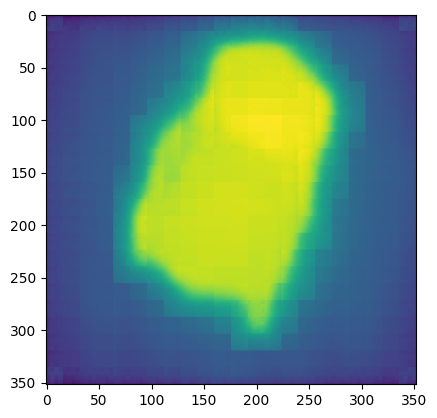

In [15]:
plt.imshow(segmented[4].cpu().reshape(352,352,1))

In [16]:
# ! a ray can be expressed as the ray direction and ray origin
from IPython.display import clear_output
# from skimage.transform import resize
depth_samples_per_ray = 10

# focal_length = focal
# record_pts = {}
# grads = []
# threshold = 0.1
# # ! for some reason the 
# # ray origin, ray  direction, importance
# important_rays = []
# point_colors = []

cams = []

dec = 2
for i in range(len(images)):
    image = images[i]
    transform = tform_cam2world[i]
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               transform)
    # print(ray_origins[0][0])
    cams.append(ray_origins[0][0])
cams = torch.stack(cams).cpu()

c:\ProgramData\Miniconda3\envs\nerfresearch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
import plotly.graph_objects as go
import random

def thresh(x,threshold=0.6):
    if x > threshold:
        return 1
    else:
        return 0
    

point_graph = go.Scatter3d(
        x=cams[:,0],
        y=cams[:,1],
        z=cams[:,2],

        mode='markers',

        marker=dict(
            size = 3,
        
        ))

# layout = go.Layout(
#     scene = {
#     'xaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'yaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'zaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'aspectmode': 'cube'
#     }
# )
fig = go.Figure(data=point_graph, axis = False)
fig.show()

Recorded Points: 0
torch.Size([400, 400, 20, 3])
tensor([-1.0572,  2.5740,  2.9166], device='cuda:0') torch.Size([400, 400, 20, 3])
[400, 400, 1]


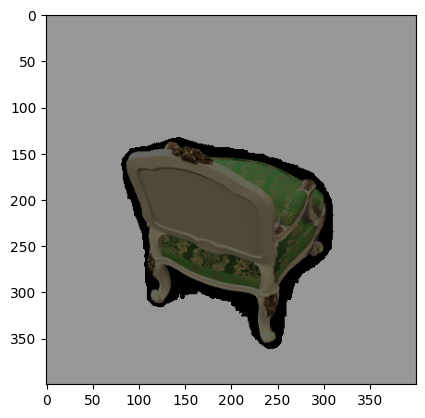

Image: 1
Repeated Points: 0
Relevant Pixels: 34181
Processing Time: 36.6291286945343
Recorded Points: 657280
torch.Size([400, 400, 20, 3])
tensor([ 0.2604, -0.2454,  4.0152], device='cuda:0') torch.Size([400, 400, 20, 3])
[400, 400, 1]


In [18]:
# ! a ray can be expressed as the ray direction and ray origin
from IPython.display import clear_output
from skimage.transform import resize
import time
depth_samples_per_ray = 20

near = 2
far = 6

# focal_length = focal
record_pts = {}
grads = []
threshold = 0.1
# ! for some reason the 
# ray origin, ray  direction, importance
important_rays = []
point_colors = []

dec = 2
for i in range(len(images)):
    start = time.time()
    print("Recorded Points:",len(record_pts.keys()))
    image = images[i].to(device)
    transform = tform_cam2world[i].to(device)
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               transform)
    query_points, depth_values = compute_query_points_from_rays(
    ray_origins, ray_directions, near, far, depth_samples_per_ray, randomize = True)
    print(query_points.shape)
    print(ray_origins[0][0],query_points.shape)
    counter = 0
            
    img_rays = []
    img_clrs = []
    
    img_shape = list(images[0].shape)
    img_shape[-1] = 1
    print(img_shape)
    repeats = 0
    cleaned_grads = resize(torch.sigmoid(segmented[i].cpu()).reshape(352,352,1).numpy(),img_shape)
    relevant_pixels = 0
    for x in range(cleaned_grads.shape[0]):
        for y in range(cleaned_grads.shape[1]):
            if sum(cleaned_grads[x][y]) > threshold:
                relevant_pixels += 1
                # pixel x,y is semantically important
                ray = query_points[x][y]
                rounded = torch.round(ray,decimals = dec).tolist()
                for pt in rounded:
                    pt = tuple(pt)
                    # print(pt)
                    record_pts[pt] = [1,sum(cleaned_grads[x][y]),image[x][y]]
                    # if pt in record_pts:
                    #     record_pts[pt] = [1,sum(cleaned_grads[x][y]),image[x][y]]
                    # else:
                    #     original = record_pts[pt][1]
                    #     # print(abs(sum(image[x][y] - record_pts[pt][2])))
                    #     if abs(sum(image[x][y] - record_pts[pt][2])) < 0.5:
                    #         # print(x,y,pt,pt in record_pts)
                    #         repeats += 1
                    #         record_pts[pt][0] += 1
                    #         record_pts[pt][1] = (sum(cleaned_grads[x][y]) + record_pts[pt][1])/record_pts[pt][0]
            
    plt.imshow(image.cpu().numpy())
    plt.imshow(cleaned_grads > threshold,alpha = 0.6,cmap = "binary")
    plt.show()
    print("Image:",i+1)
    print("Repeated Points:",repeats)
    print("Relevant Pixels:",relevant_pixels)
    print("Processing Time:",time.time()-start)
    
    if i % 10 == 0 and i != 0:
        clear_output()
    grads.append(cleaned_grads)

In [26]:
import math
import random
real_pts = []
xs = []
ys = []
zs = []
sizes = []
clrs = []

empty = []
for key in record_pts.keys():
    if (record_pts[key][0] >= 3 and record_pts[key][1] > 0):
        real_pts.append(key)
        xs.append(key[0])
        ys.append(key[1])
        zs.append(key[2])
        sizes.append(record_pts[key][1])
        clrs.append(record_pts[key][2])
    # else:
    #     empty.append(key)
        

In [25]:
len(xs)

0

In [23]:
import plotly.graph_objects as go
import random

def thresh(x,threshold=0.6):
    if x > threshold:
        return 1
    else:
        return 0
    
point_graph = go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,

        mode='markers',

        marker=dict(
            color=[tuple(clrs[i].tolist()) for i in range(len(sizes))],
            size = 0.3,
        
        ))

cameras = go.Scatter3d(
        x=cams[:,0],
        y=cams[:,1],
        z=cams[:,2],

        mode='markers',

        marker=dict(
            size = 3,
        
        ))

# layout = go.Layout(
#     scene = {
#     'xaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'yaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'zaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'aspectmode': 'cube'
#     }
# )
fig = go.Figure(data=[point_graph])
fig.show()

# Open3D

Write an algorithm that considers importance value in calculations

Do this by looking at the Open3D outlier algorithm.

Adapt the code !!

In [95]:
import open3d as o3d
import numpy as np

colors = torch.stack(clrs).cpu().numpy()
pcl = o3d.geometry.PointCloud()
pcl.points = o3d.utility.Vector3dVector(real_pts)
pcl.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcl])

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [ ]:
o3d.visualization.draw_geometries([pcl])

In [ ]:
print("Radius oulier removal")
cl, ind = pcl.remove_radius_outlier(nb_points=20, radius=0.1)
display_inlier_outlier(pcl,ind)

Radius oulier removal
Showing outliers (red) and inliers (gray): 


In [81]:
inlier_cloud = pcl.select_by_index(ind)
o3d.visualization.draw_geometries([inlier_cloud])

KeyboardInterrupt: 

## Point Pruning

In [ ]:
import os
import sys
import torch
import pytorch3d

In [ ]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"

# Load point cloud
# pointcloud = np.load(obj_filename)
# verts = torch.Tensor(pointcloud['verts']).to(device)
        
# rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[torch.Tensor(real_pts)],features=[torch.stack(clrs)])

In [ ]:
from pytorch3d.renderer import OrthographicCameras
def interpret_blender_cameras(
    poses, focal):
    """
    Convert 4x4 matrices representing cameras in blender format
    to PyTorch3D format.

    Args:
        poses: N x 3 x 4 camera matrices
        focal: ndc space focal length
    """
    pose_target_cameras = []
    for pose_target in poses:
        pose_target = pose_target[:3, :4]
        mtx = torch.eye(4, dtype=pose_target.dtype)
        mtx[:3, :3] = pose_target[:3, :3].t()
        mtx[3, :3] = pose_target[:, 3]
        mtx = mtx.inverse()

        # flip the XZ coordinates.
        mtx[:, [0, 2]] *= -1.0

        Rpt3, Tpt3 = mtx[:, :3].split([3, 1], dim=0)

        focal_length_pt3 = torch.FloatTensor([[focal, focal]])
        principal_point_pt3 = torch.FloatTensor([[0.0, 0.0]])

        cameras = OrthographicCameras(
            focal_length=focal_length_pt3,
            principal_point=principal_point_pt3,
            R=Rpt3[None],
            T=Tpt3
        )
        pose_target_cameras.append(cameras)
    return pose_target_cameras

focal_ndc = 2 * focal_length / min(100, 100)

cams = interpret_blender_cameras(tform_cam2world[0].unsqueeze(0),focal_ndc)

In [ ]:
# Initialize a camera.
num = random.randint(1,100)
cams = interpret_blender_cameras(tform_cam2world[num].unsqueeze(0),focal_ndc)
cameras = cams[0]

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=100, 
    radius = 0.01,
    points_per_pixel = 10
    
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
# rasterizer = PointsRasterizer(cameras=cameras)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

imgs = renderer(point_cloud)
f, ax = plt.subplots(1,2)
ax[0].imshow(imgs[0, ..., :3].cpu().numpy())
ax[1].imshow(images[num])
plt.axis("off");

# Use Depth Estimation

## Clip Segmentation

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined",device_map = torch.device(device))
clipseg = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined", device_map = torch.device(device))

In [ ]:
# ! a ray can be expressed as the ray direction and ray origin
from IPython.display import clear_output
# ray origin, ray  direction, importance
important_rays = []
point_colors = []
try:
  imgs = (images).astype(np.uint8)
except:
  imgs = (images.cpu().numpy()*255).astype(np.uint8)
prompts = ["chair" for i in range(len(imgs))]
inputs = processor(text=prompts, images=imgs, return_tensors="pt").to(device)
print("done")
with torch.no_grad():
  outputs = clipseg(**inputs)

segmented = outputs.logits.unsqueeze(1)

In [ ]:
torch.cuda.get_device_name()

In [ ]:
plt.imshow(segmented[3].cpu().reshape(352,352,1))

## Depth Estimation

In [ ]:
import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image

model_type = "DPT_Large"  
midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
# midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

In [ ]:
midas_transforms.dpt_transform

In [ ]:
# for i, input in enumerate(inputs):
#   dm_tmp = dir_tmp+basename(input)+'_depthmap'+path_ext(input)
#   dm_file = output_dir+basename(input)+'_depthmap'+path_ext(input)
#   disp_dm_file = dm_file.replace(drive_root, '')
#   if os.path.isfile(dm_file) and skip_existing is True:
#     op(c.warn, 'File already exists, skipping', disp_dm_file)
#   else:
# img = cv2.imread(input)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
depth = []
counter = 0
for image in images:
    counter += 1
    img = image.cpu().numpy()*255
    input_batch = transform(img).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze() 
    print("Image {}".format(counter))
    if counter % 10 == 0:
        clear_output()
    depth.append(prediction.cpu().numpy())

In [ ]:
depth[0].shape

In [ ]:
plt.imshow(depth[3].reshape(depth[0].shape[0],depth[0].shape[1],1),cmap = "binary")
plt.colorbar()
plt.show()

# ! given depth estimation, use inverse depth to place point

## Open 3D Visualisation

In [ ]:
from PIL import Image
import numpy as np
color = Image.open(r"C:\Users\victo\Desktop\Files\Tech\Data\nerf_synthetic\nerf_synthetic\chair\test\r_11.png")
depth = Image.open(r"C:\Users\victo\Desktop\Files\Tech\Data\nerf_synthetic\nerf_synthetic\chair\test\r_11_depth_0000.png")
color = np.array(color.getdata())
depth = np.array(depth.getdata())

In [ ]:
import open3d

In [ ]:
depth_map = depth[3]
plt.imshow(depth_map)
camera = open3d.camera.PinholeCameraIntrinsic()
camera.set_intrinsics(width = 100,height = 100, fx = focal_length.item(),fy = 10, cx = 0, cy = 0)

In [ ]:
pcd = []
CX_DEPTH = 0
CY_DEPTH = 0

FX_DEPTH = focal_length.item()
FY_DEPTH = focal_length.item()
height, width = depth_map.shape
for i in range(height):
   for j in range(width):
       z = depth_map[i][j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       pcd.append([x, y, z])

In [ ]:
points = torch.tensor(pcd)

In [ ]:
import plotly.graph_objects as go
import random

def thresh(x,threshold=0.6):
    if x > threshold:
        return 1
    else:
        return 0
    

point_graph = go.Scatter3d(
        x=points[:,0],
        y=points[:,1],
        z=points[:,2],

        mode='markers',

        marker=dict(
            size = 3,
        
        ))

# layout = go.Layout(
#     scene = {
#     'xaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'yaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'zaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'aspectmode': 'cube'
#     }
# )
fig = go.Figure(data=point_graph)
fig.show()

## Depth Map Visualisation

In [ ]:
idx = np.random.randint(1,len(images))
# idx = 26
depth_map = torch.Tensor(depth[idx])
print(torch.min(depth_map))
depth_map -= torch.min(depth_map)
depth_map /= torch.max(depth_map)
plt.imshow(depth_map)
plt.colorbar()

In [ ]:
from torchvision.utils import save_image
idx = 0
depth_map = torch.Tensor(depth[idx])
print(torch.min(depth_map))
depth_map -= torch.min(depth_map)
depth_map /= torch.max(depth_map)
plt.imshow(depth_map)
save_image(img, 'chair_depth.png')

In [ ]:
import math
transform = tform_cam2world[idx]
image = images[idx]
ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               transform)
origin = ray_origins[0][0]
direction = ray_directions[0][0]

pts = []
clrs = []
for x in range(len(depth_map)):
    for y in range(len(depth_map[0])):
        if not (image[x][y] == torch.Tensor([0,0,0])).all():
            direction = ray_directions[x][y]
            
            depth_val = 1-depth_map[x][y]
            point = origin + direction * (2+(6-2)*depth_val)
            # print(point)
            clrs.append(image[x][y])
            pts.append(point)

In [ ]:
import plotly.graph_objects as go
import random

points = torch.stack(pts)

def thresh(x,threshold=0.6):
    if x > threshold:
        return 1
    else:
        return 0
    

point_graph = go.Scatter3d(
        x=points[:,0],
        y=points[:,1],
        z=points[:,2],

        mode='markers',

        marker=dict(
            size = 3,
            color=[tuple(clrs[i].tolist()) for i in range(len(pts))]
        ))

cameras = go.Scatter3d(
        x=np.array(origin.cpu().numpy()[0]),
        y=np.array(origin.cpu().numpy()[1]),
        z=np.array(origin.cpu().numpy()[2]),

        mode='markers',

        marker=dict(
            size = 10,
        
        ))

# layout = go.Layout(
#     scene = {
#     'xaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'yaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'zaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'aspectmode': 'cube'
#     }
# )
# layout = go.Layout(
#     scene = {
#     'xaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'yaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'zaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'aspectmode': 'cube'
#     }
# )
fig = go.Figure(data=[point_graph,cameras])
fig.show()

## Find Points

In [ ]:
# ! a ray can be expressed as the ray direction and ray origin
from IPython.display import clear_output
from skimage.transform import resize
depth_samples_per_ray = 10
cams = []

dec = 2
for i in range(len(images)):
    image = images[i]
    transform = tform_cam2world[i]
    ray_origins, ray_directions = get_ray_bundle(H, W, focal,
                                               transform)
    # print(ray_origins[0][0])
    cams.append(ray_origins[0][0])
cams = torch.stack(cams)

In [ ]:
import plotly.graph_objects as go
import random

def thresh(x,threshold=0.6):
    if x > threshold:
        return 1
    else:
        return 0
    

point_graph = go.Scatter3d(
        x=cams[:,0],
        y=cams[:,1],
        z=cams[:,2],

        mode='markers',

        marker=dict(
            size = 3,
        
        ))



# layout = go.Layout(
#     scene = {
#     'xaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'yaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'zaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
#     'aspectmode': 'cube'
#     }
# )
fig = go.Figure(data=point_graph)
fig.show()

In [ ]:
# ! a ray can be expressed as the ray direction and ray origin
from IPython.display import clear_output
from skimage.transform import resize
import time
depth_samples_per_ray = 100

threshold = 0.1
# ! for some reason the 
clrs = []
pts = []

dec = 2
# ! to upodate!!!
for i in range(len(images)):
    start = time.time()
    # print(len(record_pts.keys()))
    image = images[i].to(device)
    transform = tform_cam2world[i].to(device)
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               transform)
    cleaned_grads = resize(torch.sigmoid(segmented[i].cpu()).reshape(352,352,1).numpy(),image.shape)
    print(cleaned_grads.shape)
    depth_map = torch.Tensor(depth[i])
    depth_map -= torch.min(depth_map)
    depth_map /= torch.max(depth_map)
    relevant_pixels = 0
    
    ray_origin = ray_origins[0][0]
    for x in range(cleaned_grads.shape[0]):
        for y in range(cleaned_grads.shape[1]):
            if sum(cleaned_grads[x][y]) > threshold:
                relevant_pixels += 1
                # pixel x,y is semantically important
                # ray = query_points[x][y]
                depth_val = 1 - depth_map[x][y]
                
                # ray_origin = ray_origins[0][0]
                ray_direction = ray_directions[x][y]
                
                point = ray_origin + ray_direction * (2+(6-2)*depth_val)
                # print(point)
                # print(depth_val)
                # # point = tuple(torch.round(point,decimals = 3).tolist())
                # if not(point in pts):
                pts.append(point,2)
                clrs.append(image[x][y])
    plt.imshow(image.cpu().numpy())
    plt.imshow(cleaned_grads,alpha = 0.6,cmap = "binary")
    plt.imshow(1/depth_map, alpha = 0.2, cmap = "magma")
    plt.show()
    print("Image:",i+1)
    print("Relevant Pixels:",relevant_pixels)
    print("Retrieved Points:",len(pts))
    # print(pts)
    print("Processing Time:",time.time()-start)
    
    if i % 10 == 0 and i != 0:
        clear_output()

In [ ]:
len(pts),len(clrs)

In [ ]:
for point in pts:
    if pts[point] 

In [ ]:
len(clrs)

In [ ]:
import plotly.graph_objects as go
import random
    
points = torch.stack(pts[:len(clrs)]).cpu()[:160000]
point_graph = go.Scatter3d(
        x=[pt[0] for pt in points],
        y=[pt[1] for pt in points],
        z=[pt[2] for pt in points],

        mode='markers',

        marker=dict(
            color=[tuple(clrs[i].tolist()) for i in range(len(points))],
            size = 1,
        
        ))

cameras = go.Scatter3d(
        x=cams[:,0],
        y=cams[:,1],
        z=cams[:,2],

        mode='markers',

        marker=dict(
            size = 5,
        
        ))

# # layout = go.Layout(
# #     scene = {
# #     'xaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
# #     'yaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
# #     'zaxis': {'range': [-2, 2], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
# #     'aspectmode': 'cube'
# #     }
# # )
fig = go.Figure(data=[point_graph,cameras])
fig.show()

In [ ]:
clrs

In [ ]:
pts[30000]

# Misc

## Depth Estimation

In [ ]:
import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image

model_type = "DPT_Large"  
midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
# midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

In [ ]:
midas_transforms.dpt_transform

In [ ]:
plt.imshow(images[11])

In [ ]:
images[11][0]

In [ ]:


# for i, input in enumerate(inputs):
#   dm_tmp = dir_tmp+basename(input)+'_depthmap'+path_ext(input)
#   dm_file = output_dir+basename(input)+'_depthmap'+path_ext(input)
#   disp_dm_file = dm_file.replace(drive_root, '')
#   if os.path.isfile(dm_file) and skip_existing is True:
#     op(c.warn, 'File already exists, skipping', disp_dm_file)
#   else:
# img = cv2.imread(input)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = images[12].numpy()*255
input_batch = transform(img).to(device)
with torch.no_grad():
    prediction = midas(input_batch)
    # prediction = torch.nn.functional.interpolate(
    #     prediction.unsqueeze(1),
    #     size=img.shape[:2],
    #     mode="bicubic",
    #     align_corners=False,
    # ).squeeze()

output = prediction.cpu().numpy()

In [ ]:
plt.imshow(output.reshape(384,384,1),cmap = "binary")
plt.colorbar()
plt.show()

# ! given depth estimation, use inverse depth to place point

## Point Cloud Rendering

In [ ]:
import os
import sys
import torch
import pytorch3d

In [ ]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"

# Load point cloud
# pointcloud = np.load(obj_filename)
# verts = torch.Tensor(pointcloud['verts']).to(device)
        
# rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[torch.Tensor(real_pts)],features=[torch.stack(clrs)])

In [ ]:
from pytorch3d.renderer import OrthographicCameras
def interpret_blender_cameras(
    poses, focal):
    """
    Convert 4x4 matrices representing cameras in blender format
    to PyTorch3D format.

    Args:
        poses: N x 3 x 4 camera matrices
        focal: ndc space focal length
    """
    pose_target_cameras = []
    for pose_target in poses:
        pose_target = pose_target[:3, :4]
        mtx = torch.eye(4, dtype=pose_target.dtype)
        mtx[:3, :3] = pose_target[:3, :3].t()
        mtx[3, :3] = pose_target[:, 3]
        mtx = mtx.inverse()

        # flip the XZ coordinates.
        mtx[:, [0, 2]] *= -1.0

        Rpt3, Tpt3 = mtx[:, :3].split([3, 1], dim=0)

        focal_length_pt3 = torch.FloatTensor([[focal, focal]])
        principal_point_pt3 = torch.FloatTensor([[0.0, 0.0]])

        cameras = OrthographicCameras(
            focal_length=focal_length_pt3,
            principal_point=principal_point_pt3,
            R=Rpt3[None],
            T=Tpt3
        )
        pose_target_cameras.append(cameras)
    return pose_target_cameras

focal_ndc = 2 * focal_length / min(100, 100)

cams = interpret_blender_cameras(tform_cam2world[0].unsqueeze(0),focal_ndc)

In [ ]:
cams[0].R

In [ ]:
# Initialize a camera.
num = random.randint(1,100)
cams = interpret_blender_cameras(tform_cam2world[num].unsqueeze(0),focal_ndc)
cameras = cams[0]

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=100, 
    radius = 0.01,
    points_per_pixel = 10
    
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
# rasterizer = PointsRasterizer(cameras=cameras)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

imgs = renderer(point_cloud)
f, ax = plt.subplots(1,2)
ax[0].imshow(imgs[0, ..., :3].cpu().numpy())
ax[1].imshow(images[num])
plt.axis("off");

In [ ]:
renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
imgs[0].shape

In [ ]:
raster_settings

In [ ]:
rendered = []

for i in range(len(images)):
    cams = interpret_blender_cameras(tform_cam2world[i].unsqueeze(0),focal_ndc)[0]
    
    rasterizer = PointsRasterizer(cameras=cams, raster_settings=raster_settings)
    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor()
    )
    img = renderer(point_cloud)[0]
    rendered.append(img.numpy())
    print("Rendered Image:",i)
# imgs

## Keras Model

In [ ]:
from keras.layers import Input,Dense,Conv2D,Conv2DTranspose,MaxPool2D
from keras import Model
import tensorflow as tf

input_layer = Input((100,100,3))
x = Conv2D(64,2,strides = 2, activation = "relu")(input_layer)
# x = MaxPool2D(2,2)(x)
x = Conv2D(64,2,strides = 2, activation = "relu")(x)

x = Conv2DTranspose(64,2,strides = 2, activation = "relu")(x)
x = Conv2DTranspose(3,2,strides = 2, activation = "relu")(x)
# x.shape

In [ ]:
from keras.layers import Input,Dense,Conv2D,Conv2DTranspose,MaxPool2D,Flatten,Reshape
from keras import Model

input_layer = Input((100,100,3))
x = Flatten()(input_layer)
x = Dense(32)(x)
x = Dense(64)(x)
x = Dense(128)(x)
x = Dense(30000)(x)
x = Reshape((100,100,3))(x)

In [ ]:
from keras.layers import Input,Dense,Conv2D,Conv2DTranspose,MaxPool2D
from keras import Model
import tensorflow as tf

# input_layer = Input((100,100,3))
# x = Conv2D(64,2,strides = 2, activation = "relu")(input_layer)
# # x = MaxPool2D(2,2)(x)
# x = Conv2D(64,2,strides = 2, activation = "relu")(x)

# x = Conv2DTranspose(64,3,strides = 2, activation = "relu")(x)
# x = Conv2DTranspose(64,3,strides = 2, activation = "relu")(x)
# x = Conv2DTranspose(64,2,strides = 2, activation = "relu")(x)
# x = Conv2D(3,3)(x)

model = Model(input_layer,x)

model(np.random.randn(1,100,100,3))
model.compile(optimizer = "adam",loss = "mse")


model.fit(np.array(rendered),images.numpy(),epochs = 100)

In [ ]:
pred = model(rendered[30].reshape(1,100,100,3))[0]
plt.imshow(pred)

In [ ]:
tform_cam2world[i+1]

In [ ]:

R, T = look_at_view_transform(100, 30, 40)
cams = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

    
rasterizer = PointsRasterizer(cameras=cams, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)
img = np.array(renderer(point_cloud)[0])
pred = model(img.reshape(1,100,100,3))[0]
plt.imshow(pred)
plt.imshow(img,alpha = 0.4)

In [ ]:
plt.imshow(img)

## Pytorch Model

In [ ]:
import time 
num_iters = 100

# model = ConvAutoencoder()
optimizer = torch.optim.Adam(model.parameters())

loss_fn = torch.nn.MSELoss()
losses = []

for x in range(num_iters):
    iter_loss = 0
    for i in range(len(images)):
        label = images[i]
        render = rendered[i].reshape(3,100,100)
        # print(render.shape)
        
        optimizer.zero_grad()
        
        pred = model.forward(render).reshape(100,100,3)
        
        loss = loss_fn(pred,label)
        loss.backward()
        
        optimizer.step()
        iter_loss += loss.item()
    print("Iteration:",x)
    losses.append(iter_loss/len(images))

In [ ]:
plt.imshow(pred.detach().numpy())

In [ ]:
num = random.randint(1,100)
plt.imshow(images[num])
plt.imshow(rendered[num],alpha=0.8)

## Using the Point Cloud

use the point cloud to prime the nerf model
- model should also have the importance values as a fifth value? or just as the density value
- fifth value may be more relevant as then can plot heatmap of more important points
- try to code the average colour value and set the importance to initial
- set the points on the ray apart from these points as being low density

In [ ]:

# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 1000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

In [ ]:
from torch import nn

def zero(layer):
    nn.init.zeros_(layer.weight)
    nn.init.zeros_(layer.bias)
class VeryTinyNerfModel(torch.nn.Module):
    r"""Define a "very tiny" NeRF model comprising three fully connected layers.
    """
    def __init__(self, filter_size=256, num_encoding_functions=6):
        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
        
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # nn.init.constant_(self.layer2.weight,0)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # nn.init.constant_(self.layer3.weight,0)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x
    
    def zero_params(self):
        zero(self.layer1)
        zero(self.layer2)
        zero(self.layer3)



In [ ]:
model = VeryTinyNerfModel(num_encoding_functions=6)
model.to(device)
# model.zero_params()


pts = torch.rand(10,3)
encoded_points = encode(torch.Tensor(pts))

model.forward(encoded_points).shape

In [ ]:
from torch import nn 
losses = []
iters = 200

# num_empty = 100000
# empty_pts = [empty[i] for i in range(num_empty)]
# model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
# model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# clrs = [val.tolist() for val in clrs] if type(clrs[0]) == torch.Tensor else clrs

# # y_true = [clrs[i]+[1] for i in range(len(real_pts))] + [[0,0,0,0] for i in range(num_empty)]
# real_clrs = [clrs[i] for i in range(len(real_pts))]
# rgb = torch.tensor(real_clrs).to(torch.float32)
pt = torch.tensor([0,0,0])
print("prep")
for n in range(100):
    # real_pts = torch.Tensor(real_pts)
    # encoded_points = encode(torch.Tensor(real_pts+empty_pts))
    encoded_points = encode(torch.Tensor(pt))
    
    y_hat = model(encoded_points).to(torch.float32)
    rgb_pred = torch.sigmoid(y_hat[..., :3])
    
    loss = nn.MSELoss()
    
    rgb_loss = loss(rgb_pred,torch.tensor([1.0]))
    density_loss = loss(y_hat[..., -1], torch.ones(1))
    
    err = rgb_loss + density_loss
    losses.append(err.item())
    err.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Iteration {}:".format(n))
    print(" RGB loss:{}".format(rgb_loss.item()))
    print(" density loss:{}".format(density_loss.item()))
    if n % 10 == 0:
        clear_output()

# batches = get_minibatches(encoded_points, chunksize=chunksize)

# y_hat = []
# for batch in batches:
#     y_hat.append(model(batch))
# y_hat = torch.Tensor(y_hat)
plt.plot(losses)

In [ ]:
target_img_idx = np.random.randint(images.shape[0])
target_img = images[target_img_idx].to(device)
target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

# Run one iteration of TinyNeRF and get the rendered RGB image.
rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                        target_tform_cam2world, near_thresh,
                                        far_thresh, depth_samples_per_ray,
                                        encode, get_minibatches)

plt.imshow(rgb_predicted.detach().numpy())

In [ ]:
real_clrs = [clrs[i] for i in range(len(record_pts))]
rgb = torch.stack(real_clrs)
print(rgb.shape)
encoded_points = encode(torch.Tensor(record_pts))
print(encoded_points.shape)
    
y_hat = model(encoded_points)
rgb_pred = torch.sigmoid(y_hat[..., :3])

loss = nn.MSELoss()

rgb_loss = loss(rgb_pred,rgb)
density_loss = loss(y_hat[..., -1], torch.ones(len(record_pts)))

err = rgb_loss + density_loss
err

In [ ]:
rgb,rgb_pred

In [ ]:
rgb_pred,rgb

In [ ]:
from torch import nn 
losses = []
iters = 200

# num_empty = 100000
# empty_pts = [empty[i] for i in range(num_empty)]
# model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
# model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
clrs = [val.tolist() for val in clrs] if type(clrs[0]) == torch.Tensor else clrs

# y_true = [clrs[i]+[1] for i in range(len(real_pts))] + [[0,0,0,0] for i in range(num_empty)]
real_clrs = [clrs[i] for i in range(len(record_pts))]
rgb = torch.tensor(real_clrs).to(torch.float32)
print("prep")
for n in range(iters):
    # real_pts = torch.Tensor(real_pts)
    # encoded_points = encode(torch.Tensor(real_pts+empty_pts))
    encoded_points = encode(torch.Tensor(record_pts))
    
    y_hat = model(encoded_points).to(torch.float32)
    rgb_pred = torch.sigmoid(y_hat[..., :3])
    
    loss = nn.MSELoss()
    
    rgb_loss = loss(rgb_pred,rgb)
    density_loss = loss(y_hat[..., -1], torch.ones(len(record_pts)))
    
    err = rgb_loss + density_loss
    losses.append(err.item())
    err.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Iteration {}:".format(n))
    print(" RGB loss:{}".format(rgb_loss.item()))
    print(" density loss:{}".format(density_loss.item()))
    if n % 10 == 0:
        clear_output()

# batches = get_minibatches(encoded_points, chunksize=chunksize)

# y_hat = []
# for batch in batches:
#     y_hat.append(model(batch))
# y_hat = torch.Tensor(y_hat)
plt.plot(losses)

In [ ]:
y_hat

In [ ]:
y_true

In [ ]:
target_img_idx = np.random.randint(images.shape[0])
target_img = images[target_img_idx].to(device)
target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

# Run one iteration of TinyNeRF and get the rendered RGB image.
rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                        target_tform_cam2world, near_thresh,
                                        far_thresh, depth_samples_per_ray,
                                        encode, get_minibatches)

plt.imshow(rgb_predicted.detach().numpy())

In [ ]:
# Lists to log metrics etc.
psnrs = []
iternums = []
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_iters = 100
display_every = 2
for i in range(num_iters):
  print(i)

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)
    
    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

In [ ]:
# find closest point for two given rays.
# most likely to be the point of intersection (i.e point of reality)
# increase density of that point and points around it,

# seems more effective, maybe just add points from rays and then calculate later
# its simply not worth it to redo all teh calculations one by one
from numpy import array, cross
from numpy.linalg import solve, norm

def closest_point(ray_1,ray_2,clampAll=False,clampA0=False,clampA1=False,clampB0=False,clampB1=False):

    ''' Given two lines defined by numpy.array pairs (a0,a1,b0,b1)
        Return the closest points on each segment and their distance
    '''

    o_1,d_1 = ray_1
    o_2,d_2 = ray_2
    
    o_1,d_1 = np.array(o_1),np.array(d_1)
    o_2,d_2 = np.array(o_2),np.array(d_2)
    
    a0 = o_1
    a1 = o_1+d_1
    
    b0 = o_2
    b1 = o_2+d_2
    # If clampAll=True, set all clamps to True
    if clampAll:
        clampA0=True
        clampA1=True
        clampB0=True
        clampB1=True


    # Calculate denomitator
    A = a1 - a0
    B = b1 - b0
    magA = np.linalg.norm(A)
    magB = np.linalg.norm(B)
    
    _A = A / magA
    _B = B / magB
    
    cross = np.cross(_A, _B);
    denom = np.linalg.norm(cross)**2
    
    
    # If lines are parallel (denom=0) test if lines overlap.
    # If they don't overlap then there is a closest point solution.
    # If they do overlap, there are infinite closest positions, but there is a closest distance
    if not denom:
        d0 = np.dot(_A,(b0-a0))
        
        # Overlap only possible with clamping
        if clampA0 or clampA1 or clampB0 or clampB1:
            d1 = np.dot(_A,(b1-a0))
            
            # Is segment B before A?
            if d0 <= 0 >= d1:
                if clampA0 and clampB1:
                    if np.absolute(d0) < np.absolute(d1):
                        midpoint = (a0+b0)/2
                        return midpoint,abs(np.linalg.norm(midpoint- (o_1 + d_1 * midpoint[0])))+abs(np.linalg.norm(midpoint- (o_2 + d_2 * midpoint[0])))
                    midpoint = (a0+b1)/2
                    return midpoint,abs(np.linalg.norm(midpoint- (o_1 + d_1 * midpoint[0])))+abs(np.linalg.norm(midpoint- (o_2 + d_2 * midpoint[0])))
                
                
            # Is segment B after A?
            elif d0 >= magA <= d1:
                if clampA1 and clampB0:
                    if np.absolute(d0) < np.absolute(d1):
                        midpoint = (a1+b0)/2
                        return midpoint,abs(np.linalg.norm(midpoint- (o_1 + d_1 * midpoint[0])))+abs(np.linalg.norm(midpoint- (o_2 + d_2 * midpoint[0])))
                    midpoint = (a1+b1)/2
                    return (a1+b1)/2,abs(np.linalg.norm(midpoint- (o_1 + d_1 * midpoint[0])))+abs(np.linalg.norm(midpoint- (o_2 + d_2 * midpoint[0])))
                
                
        # Segments overlap, return distance between parallel segments
        return None,0
        
    
    
    # Lines criss-cross: Calculate the projected closest points
    t = (b0 - a0);
    detA = np.linalg.det([t, _B, cross])
    detB = np.linalg.det([t, _A, cross])

    t0 = detA/denom;
    t1 = detB/denom;

    pA = a0 + (_A * t0) # Projected closest point on segment A
    pB = b0 + (_B * t1) # Projected closest point on segment B


    # Clamp projections
    if clampA0 or clampA1 or clampB0 or clampB1:
        if clampA0 and t0 < 0:
            pA = a0
        elif clampA1 and t0 > magA:
            pA = a1
        
        if clampB0 and t1 < 0:
            pB = b0
        elif clampB1 and t1 > magB:
            pB = b1
            
        # Clamp projection A
        if (clampA0 and t0 < 0) or (clampA1 and t0 > magA):
            dot = np.dot(_B,(pA-b0))
            if clampB0 and dot < 0:
                dot = 0
            elif clampB1 and dot > magB:
                dot = magB
            pB = b0 + (_B * dot)
    
        # Clamp projection B
        if (clampB0 and t1 < 0) or (clampB1 and t1 > magB):
            dot = np.dot(_A,(pB-a0))
            if clampA0 and dot < 0:
                dot = 0
            elif clampA1 and dot > magA:
                dot = magA
            pA = a0 + (_A * dot)

    midpoint = (pA+pB)/2
    return midpoint,abs(np.linalg.norm(midpoint- (o_1 + d_1 * midpoint[0])))+abs(np.linalg.norm(midpoint- (o_2 + d_2 * midpoint[0])))

def get_ray(origin,direction,num_pts=10):
    origin = np.array(origin)
    direction = np.array(direction)
    pts = ray_origins[x]
    # Data for a three-dimensional line
    pts = [origin+direction*i for i in range(num_pts)]
    xdata = [pt[0] for pt in pts]
    ydata =  [pt[1] for pt in pts]
    zdata = [pt[2] for pt in pts]
    return xdata,ydata,zdata

In [ ]:
import random
import csv
diff = 0.3
num_stochastic = 10
real_pts = []
importances = []
real_clrs = []

xs = []
ys = []
zs = []

for img_1 in range(len(important_rays)):
    print("On Image",img_1)
    with open('xs.csv', 'w') as f:
        write = csv.writer(f)
        write.writerow(xs)
    with open('ys.csv', 'w') as f:
        write = csv.writer(f)
        write.writerow(ys)
    with open('zs.csv', 'w') as f:
        write = csv.writer(f)
        write.writerow(zs)
    for idx_1 in range(len(important_rays[img_1])):
        ray_1 = important_rays[img_1][idx_1]
        for img_2 in range(len(important_rays)):
            x = None
            y= None
            z= None
            colours = None
            for idx_2 in range(num_stochastic):
                if important_rays[img_2]:
                    idx_2 = random.randint(0,len(important_rays[img_2])-1)
                    ray_2 = important_rays[img_2][idx_2]
                    color_diff = abs(sum(point_colors[img_1][idx_1]-point_colors[img_2][idx_2]))
                    if color_diff > diff or 0 in point_colors[img_2][idx_2] or 0 in point_colors[img_1][idx_1]:
                        pass
                    else:
                        intersection_point,distance = closest_point(ray_1,ray_2)
                        #print(distance)
                        if type(intersection_point) != type(None) and not intersection_point.tolist() in real_pts and distance < 0.5:
                            x = intersection_point[0]
                            y = intersection_point[1]
                            z = intersection_point[2]
                            colours = [point_colors[img_1][idx_1],point_colors[img_2][idx_2]]
            if x:
                xs.append(x)
                ys.append(y)
                zs.append(z)
                real_clrs.append(colours)
                break
            print(img_1,idx_1,img_2,idx_2,len(real_clrs))
            if img_2 % 100 == 0:
                clear_output()

In [ ]:
import plotly.graph_objects as go
import random

point_graph = go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,

        mode='markers',

        marker=dict(
            # color=['rgb{}'.format(tuple(clr*255)) for clr in real_clrs],
            color=['rgb{}'.format(tuple(torch.round(((clr[0]+clr[1])/2*255)).tolist())) for clr in real_clrs],
            opacity=0.3,
        ))

layout = go.Layout(
    scene = {
    'xaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'yaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'zaxis': {'range': [-5, 5], 'rangemode': 'tozero', 'tickmode': "linear", 'tick0': -5, 'dtick': 1},
    'aspectmode': 'cube'
    }
)
fig = go.Figure(data=point_graph,layout = layout)
fig.show()

In [ ]:
print("hello")

In [ ]:
clr = real_clrs[0]
torch.round(((clr[0]+clr[1])/2*255)).tolist()